In [1]:
!pip3 install psycopg2

You are using pip version 19.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
import psycopg2
import requests
import pandas as pd
from psycopg2.extras import RealDictCursor

In [3]:
conn = psycopg2.connect(
    database='reboard-api',
    host='176.112.192.94',
    user='postgres',
    password='postgres',
    cursor_factory=RealDictCursor
)

def query(q):
    with conn:
        with conn.cursor() as cur:
            cur.execute(q)
            res = cur.fetchall()
    return pd.DataFrame(res)

In [4]:
data = query("""
    select
        ge_timestamp_event as event_timestamp,
        ge_session_id as user_pseudo_id,
        ge_event_name as event_name
    from pixel.game_event
    order by event_timestamp
""")
data.head()

,event_timestamp,user_pseudo_id,event_name
0,2019-06-29 16:12:29,1561816724099|1,tech_screen_change_mainmenu
1,2019-06-29 16:12:33,1561816724099|1,tech_screen_change_scores
2,2019-06-29 16:12:35,1561816724099|1,tech_screen_change_mainmenu
3,2019-06-29 16:13:57,1560695147351|1,tech_screen_change_mainmenu
4,2019-06-29 16:14:00,1560695147351|1,pregame_start_game


To get your unique game id:
1. Open [reboardgame](http://reboardgame.com/)
2. Open browser console (usually you can click F12)
3. Execute in console following command 
```js
localStorage.getItem('reboard_session_id')
```

In [5]:
# put here your user_id
user_id = '1562080639630|1'

# this will show your events
data[data.user_pseudo_id == user_id]

,event_timestamp,user_pseudo_id,event_name
4315,2019-07-02 15:17:19,1562080639630|1,tech_screen_change_mainmenu
4390,2019-07-02 15:42:43,1562080639630|1,tech_screen_change_mainmenu
4391,2019-07-02 15:43:10,1562080639630|1,tech_screen_change_mainmenu


In [6]:
from retentioneering import init_config
import pandas as pd

In [7]:
data[data.event_name == 'tech_screen_change_scores']['user_pseudo_id'].nunique()

10

In [8]:
init_config(
    experiments_folder='experiments', # folder for saving experiment results: graph visualization, heatmaps and etc.
    index_col='user_pseudo_id', # column by which we split users / sessions / whatever
    event_col='event_name', # column that describes event
    event_time_col='event_timestamp', # column that describes timestamp of event
    positive_target_event='aftergame_winfinish', # name of positive target event
    negative_target_event='lost', # name of negative target event
    pos_target_definition={ # how to define positive event, e.g. empty means that add passed for whom was not 'lost'

    },
    neg_target_definition={ # how to define negative event, e.g. users who were inactive for 600 seconds.
        'time_limit': 600
    },
)

In [9]:
data.event_name.unique()

array(['tech_screen_change_mainmenu', 'tech_screen_change_scores',
       'pregame_start_game', 'tech_screen_change_gameplay',
       'game_board_click', 'aftergame_winfinish',
       'tech_screen_change_settings', 'pregame_change_settings',
       'tech_screen_change_team', 'pregame_button_click'], dtype=object)

In [10]:
data = data.retention.prepare()

In [11]:
edgelist = data.retention.get_edgelist()
edgelist.head()

,event_name,next_event,event_count
0,aftergame_winfinish,game_board_click,3.833333
1,aftergame_winfinish,pregame_start_game,0.958333
2,aftergame_winfinish,tech_screen_change_gameplay,0.791667
3,aftergame_winfinish,tech_screen_change_mainmenu,0.708333
4,game_board_click,aftergame_winfinish,6.416667


In [12]:
edgelist = data.retention.get_edgelist(edge_col='user_pseudo_id', edge_attributes='users_nunique', norm=False)
edgelist.sort_values('users_nunique', ascending=False).head()

,event_name,next_event,users_nunique
15,pregame_start_game,game_board_click,22
21,tech_screen_change_gameplay,pregame_start_game,22
5,game_board_click,game_board_click,22
4,game_board_click,aftergame_winfinish,21
0,aftergame_winfinish,game_board_click,20


In [13]:
data.retention.get_adjacency()

,aftergame_winfinish,game_board_click,pregame_start_game,tech_screen_change_gameplay,tech_screen_change_mainmenu,pregame_button_click,tech_screen_change_settings,pregame_change_settings,tech_screen_change_scores,tech_screen_change_team
aftergame_winfinish,0.00,3.83,0.96,0.79,0.71,0.00,0.00,0.00,0.00,0.00
game_board_click,6.42,125.38,2.04,1.58,1.42,0.00,0.00,0.00,0.00,0.00
pregame_start_game,0.00,3.83,0.08,5.12,0.58,0.00,0.04,0.00,0.00,0.00
tech_screen_change_gameplay,0.00,4.21,4.54,0.25,0.58,0.00,0.00,0.00,0.00,0.00
tech_screen_change_mainmenu,0.00,0.08,1.96,1.67,0.75,0.17,1.96,0.04,1.71,0.58
pregame_button_click,0.00,0.00,0.00,0.12,0.17,0.00,0.08,0.00,0.00,0.00
tech_screen_change_settings,0.00,0.00,0.04,0.00,0.33,0.00,0.00,1.71,0.00,0.00
pregame_change_settings,0.00,0.00,0.00,0.08,1.67,0.00,0.00,4.04,0.00,0.00
tech_screen_change_scores,0.00,0.04,0.00,0.00,1.58,0.00,0.00,0.00,0.25,0.00
tech_screen_change_team,0.00,0.00,0.00,0.00,0.38,0.21,0.00,0.00,0.00,0.00


In [14]:
data.retention.get_adjacency(edge_col='user_pseudo_id', edge_attributes='users_nunique', norm=False)

,aftergame_winfinish,game_board_click,pregame_start_game,tech_screen_change_gameplay,tech_screen_change_mainmenu,pregame_button_click,tech_screen_change_settings,pregame_change_settings,tech_screen_change_scores,tech_screen_change_team
aftergame_winfinish,0.0,20.0,11.0,10.0,8.0,0.0,0.0,0.0,0.0,0.0
game_board_click,21.0,22.0,14.0,15.0,14.0,0.0,0.0,0.0,0.0,0.0
pregame_start_game,0.0,22.0,1.0,20.0,8.0,0.0,1.0,0.0,0.0,0.0
tech_screen_change_gameplay,0.0,19.0,22.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0
tech_screen_change_mainmenu,0.0,2.0,18.0,15.0,7.0,4.0,15.0,1.0,10.0,10.0
pregame_button_click,0.0,0.0,0.0,3.0,4.0,0.0,2.0,0.0,0.0,0.0
tech_screen_change_settings,0.0,0.0,1.0,0.0,7.0,0.0,0.0,13.0,0.0,0.0
pregame_change_settings,0.0,0.0,0.0,2.0,13.0,0.0,0.0,9.0,0.0,0.0
tech_screen_change_scores,0.0,1.0,0.0,0.0,10.0,0.0,0.0,0.0,3.0,0.0
tech_screen_change_team,0.0,0.0,0.0,0.0,8.0,5.0,0.0,0.0,0.0,0.0


In [15]:
data.retention.plot_graph(thresh=0.05, width=800, height=800)

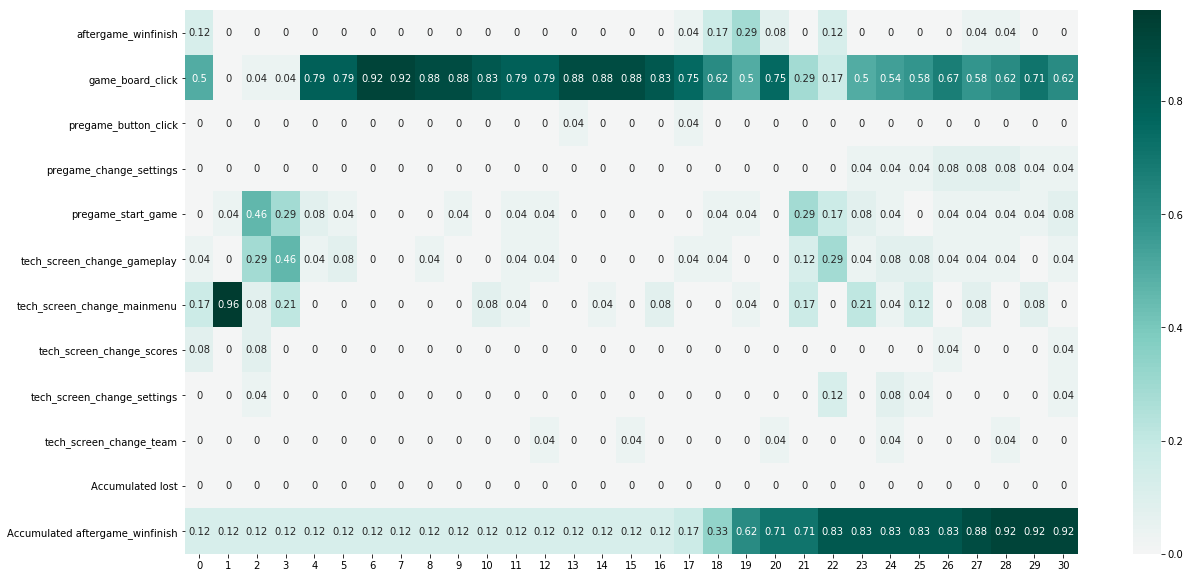

In [16]:
desc_table = data.retention.get_step_matrix(max_steps=30)

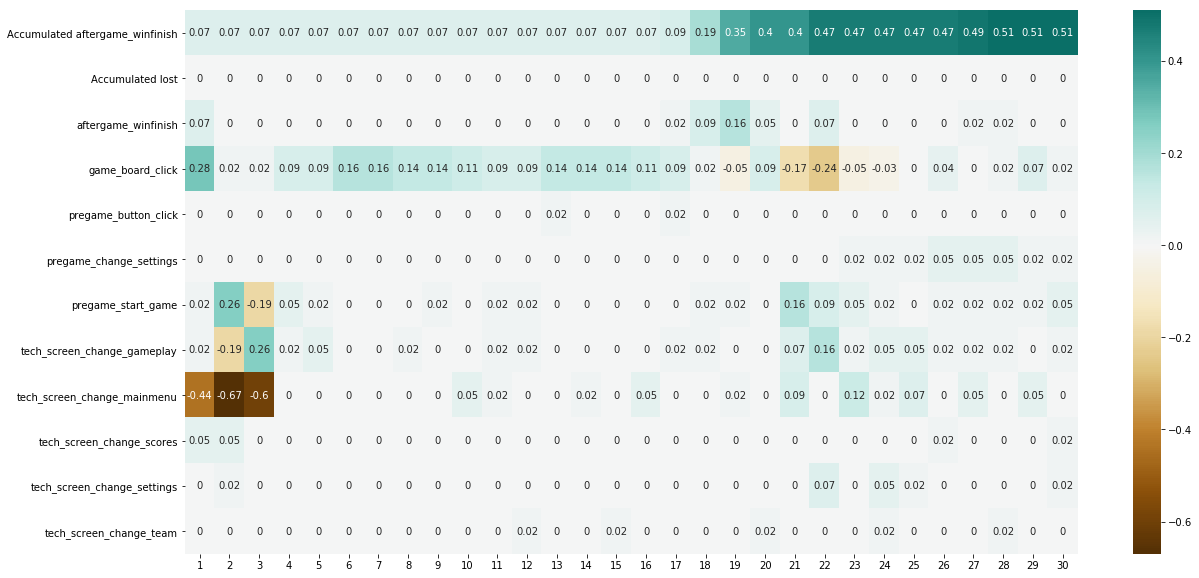

In [22]:
# create group filter based on target events
diff_filter = data.retention.create_filter()

# calculate difference table between two groups
diff_table = data.retention.get_step_matrix_difference(diff_filter, max_steps=30)

In [23]:
data.retention.get_adjacency()

,aftergame_winfinish,game_board_click,pregame_start_game,tech_screen_change_gameplay,tech_screen_change_mainmenu,pregame_button_click,tech_screen_change_settings,pregame_change_settings,tech_screen_change_scores,tech_screen_change_team
aftergame_winfinish,0.00,3.83,0.96,0.79,0.71,0.00,0.00,0.00,0.00,0.00
game_board_click,6.42,125.38,2.04,1.58,1.42,0.00,0.00,0.00,0.00,0.00
pregame_start_game,0.00,3.83,0.08,5.12,0.58,0.00,0.04,0.00,0.00,0.00
tech_screen_change_gameplay,0.00,4.21,4.54,0.25,0.58,0.00,0.00,0.00,0.00,0.00
tech_screen_change_mainmenu,0.00,0.08,1.96,1.67,0.75,0.17,1.96,0.04,1.71,0.58
pregame_button_click,0.00,0.00,0.00,0.12,0.17,0.00,0.08,0.00,0.00,0.00
tech_screen_change_settings,0.00,0.00,0.04,0.00,0.33,0.00,0.00,1.71,0.00,0.00
pregame_change_settings,0.00,0.00,0.00,0.08,1.67,0.00,0.00,4.04,0.00,0.00
tech_screen_change_scores,0.00,0.04,0.00,0.00,1.58,0.00,0.00,0.00,0.25,0.00
tech_screen_change_team,0.00,0.00,0.00,0.00,0.38,0.21,0.00,0.00,0.00,0.00


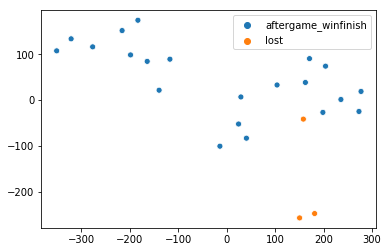

In [24]:
data.retention.learn_tsne(plot_type='targets');

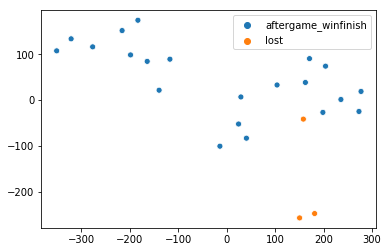

In [25]:
data.retention.learn_tsne(perplexity=5, plot_type='targets', refit=True);

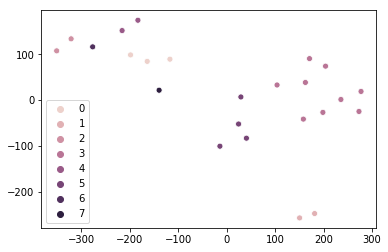

In [26]:
data.retention.get_clusters(plot_type='cluster_tsne');